# Navnet 2

Navnet version 2 approach combining self-supervised retrospective analysis, AE based anomaly detection, and patch navnet. The AE tries to predict what the right image sees based on a slightly larger patch from the left image and knowledge about where it was taken from. This one uses an STN to help with the transformation of the left image into the right image and implicity takes advantage of depth information.

In [1]:
import utils
train_path = "/home/michael/Desktop/BytesDB_train_normal/"
test_normal_path = "/home/michael/Desktop/BytesDB_test_normal/"
test_anormal_path = "/home/michael/Desktop/BytesDB_test_anormal/"

## Using Pandas for Dataloading and Management, New Data Management Class

In [2]:
train_data =  utils.BytesDataset(train_path, crop=90)
test_normal_data  =  utils.BytesDataset(test_normal_path, crop=90)
test_anormal_data  =  utils.BytesDataset(test_anormal_path, crop=90)

## Batch Handling

(90, 320, 3)


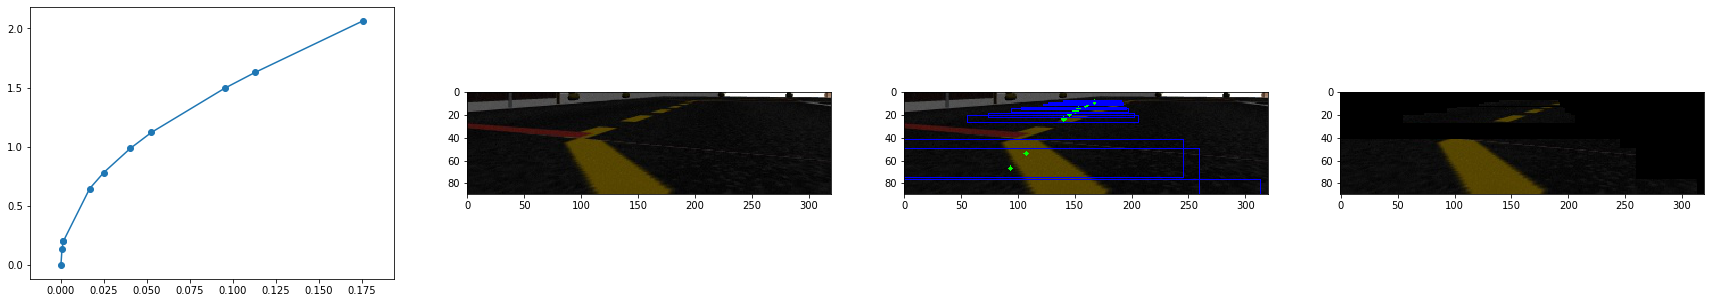

In [3]:
###### import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

source = 60
target = 70
robot_width = 0.6
crop_line = 90

image = train_data.read_cv_image(source, right=True)
print(image.shape)
image_raw = image.copy()
path = train_data.path_source_to_target(source, target)

mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

for point in path:
    point_image =  utils.project_to_image(point, right=True)
    image = cv2.circle(image, (point_image[0], point_image[1]-crop_line), 2, (0,255,0), -1) 
    
    right_corner =  utils.project_to_image([point[0] - robot_width/2, point[1] - 0.1, point[2]], right=True)
    left_corner =  utils.project_to_image([point[0] + robot_width/2, point[1] + 0.1, point[2]], right=True)
    
    image = cv2.rectangle(image, (right_corner[0], right_corner[1]-crop_line), (left_corner[0], left_corner[1]-crop_line), (0,0,255), 1) 
    
    mask = cv2.rectangle(mask, (right_corner[0], right_corner[1]-crop_line), (left_corner[0], left_corner[1]-crop_line), (255, 255, 255), -1) 
    
res = cv2.bitwise_and(image_raw, image_raw, mask=mask)
    
fig = plt.figure(figsize=(30,5))
fig.add_subplot(1,4,1)
plt.scatter(path[:,0], path[:,1])
plt.plot(path[:,0], path[:,1])
fig.add_subplot(1,4,2)
plt.imshow(image_raw)
fig.add_subplot(1,4,3)
plt.imshow(image)
fig.add_subplot(1,4,4)
plt.imshow(res)

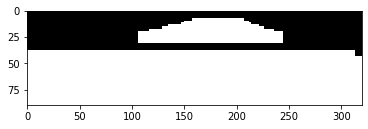

In [4]:
mask = utils.make_mask_from_path(path, vertical_crop=90, robot_width=0.6, step_height=0.3, image_shape=(90,320,3), right=False)
plt.imshow(mask)

In [5]:
mask_tensor = torch.from_numpy(mask).transpose(0,2).transpose(1,2)
print(mask_tensor.shape)

torch.Size([3, 90, 320])


In [6]:
import random

# returns right mask, right image, left mask, left image, path

def batch_generator(dataset, image_shape=(3,90,320), path_length=30, collision_buffering=35, vertical_crop=90, robot_width=0.6, max_dt=0.45, batch_size=16):
    while True:
        
        # create memory for training data
        
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        
        left_masks = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_masks = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2])) 
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source) and dataset.index_exists(rand_source+1):
                target = min(rand_source + path_length, dataset.get_next_break(rand_source)-collision_buffering-1)
                if target - rand_source > 0:
                    try:
                        
                        # make sure no breaks in the data
                        for t in range(rand_source, target):
                            if dataset.data['dt'][t] > max_dt:
                                raise Exception("too large of a skip in data recording")
                                
                        path = dataset.path_source_to_target(rand_source, target)
                        
                        mask_left = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(image_shape[1], image_shape[2], image_shape[0]))).transpose(0,2).transpose(1,2)
                        mask_right = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(image_shape[1], image_shape[2], image_shape[0]), right=True)).transpose(0,2).transpose(1,2)
                                                
                        left_images[i] = dataset.read_torch_image(rand_source)
                        left_masks[i] = mask_left

                        right_images[i] =  dataset.read_torch_image(rand_source, right=True)
                        right_masks[i] = mask_right

                        i += 1
                    except Exception as e:
                        pass
                        
        yield right_masks, right_images, left_masks, left_images

In [7]:
batch = next(batch_generator(train_data))

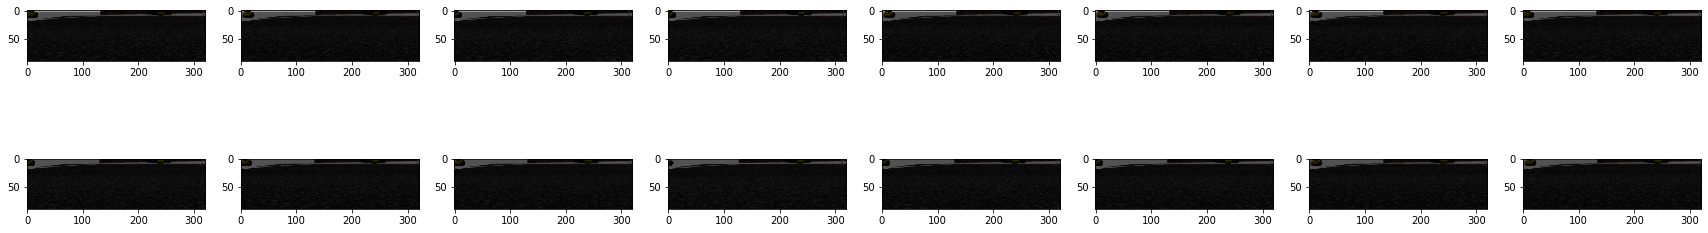

In [8]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(batch[1][i]))

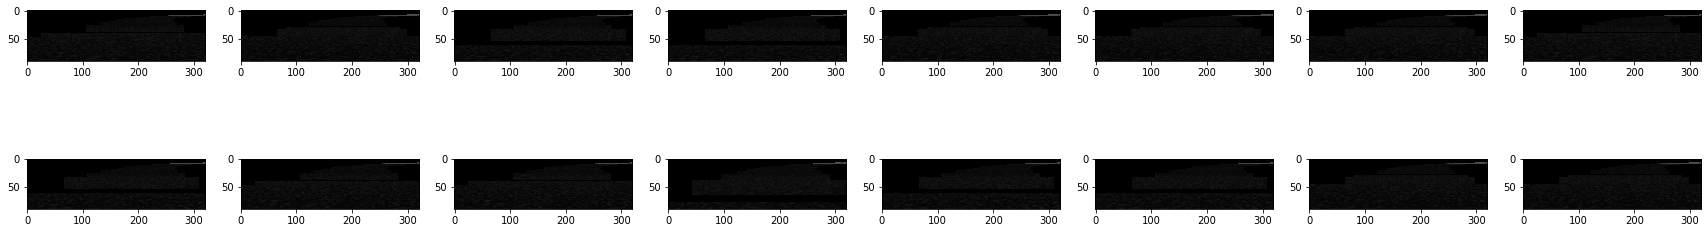

In [9]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(batch[1][i]*batch[2][i])*batch[2][i].transpose(0,2).transpose(0,1).numpy())

## Create the autoencoder model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def same_padding(stride, width, height, filter_size):
    pad_w = ((stride-1)*width-stride+filter_size)/2
    pad_h = ((stride-1)*height-stride+filter_size)/2
    return (int(pad_h),int(pad_w))

class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 90, 320)):
        super(NavNet, self).__init__()
        
        # Encoder Sets
        self.encoder_a = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.encoder_b = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.encoder_c = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        
        # takes in encoder c and transforms with stn
        self.flow_field_a = torch.nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5))
        )
        
        # Decoder Sets
        self.decoder_a = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1]//4, input_shape[2]//4)),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.decoder_b = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1]//2, input_shape[2]//2)),
            nn.Conv2d(128, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.decoder_c = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1], input_shape[2])),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],1))
        )
    
    def forward(self, img):
        
        embedding_a = self.encoder_a(img)
        embedding_b = self.encoder_b(embedding_a)
        embedding_c = self.encoder_c(embedding_b)
        
        flow_feild = self.flow_field_a(embedding_b).transpose(1,2).transpose(2,3)
        
        transformed_embedding_c = F.grid_sample(embedding_c, flow_feild, align_corners=False)
        
        # decoder with skip connections
        decoding_a = self.decoder_a(transformed_embedding_c)
        decoding_b_cat = torch.cat((embedding_b, decoding_a), dim=1) # skip 1 
        decoding_c = self.decoder_b(decoding_b_cat)
        decoding_c_cat = torch.cat((embedding_a, decoding_c), dim=1) # skip 2
        output = self.decoder_c(decoding_c_cat)
        
        return output
    
    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)
    
    def loss(self, output, right_images, alpha=0.85):
        l1_loss =  F.l1_loss(output, right_images)
        ssim_loss = torch.mean(torch.nn.functional.pad(self.SSIM(output, right_images), (1,1,1,1))) 
        return alpha*ssim_loss+(1-alpha)*l1_loss
        

In [11]:
navnet = NavNet()
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)
output = navnet.forward(batch[0])
print(output.shape)

Model Size:  627157
torch.Size([16, 3, 90, 320])


## Train the model

In [12]:
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


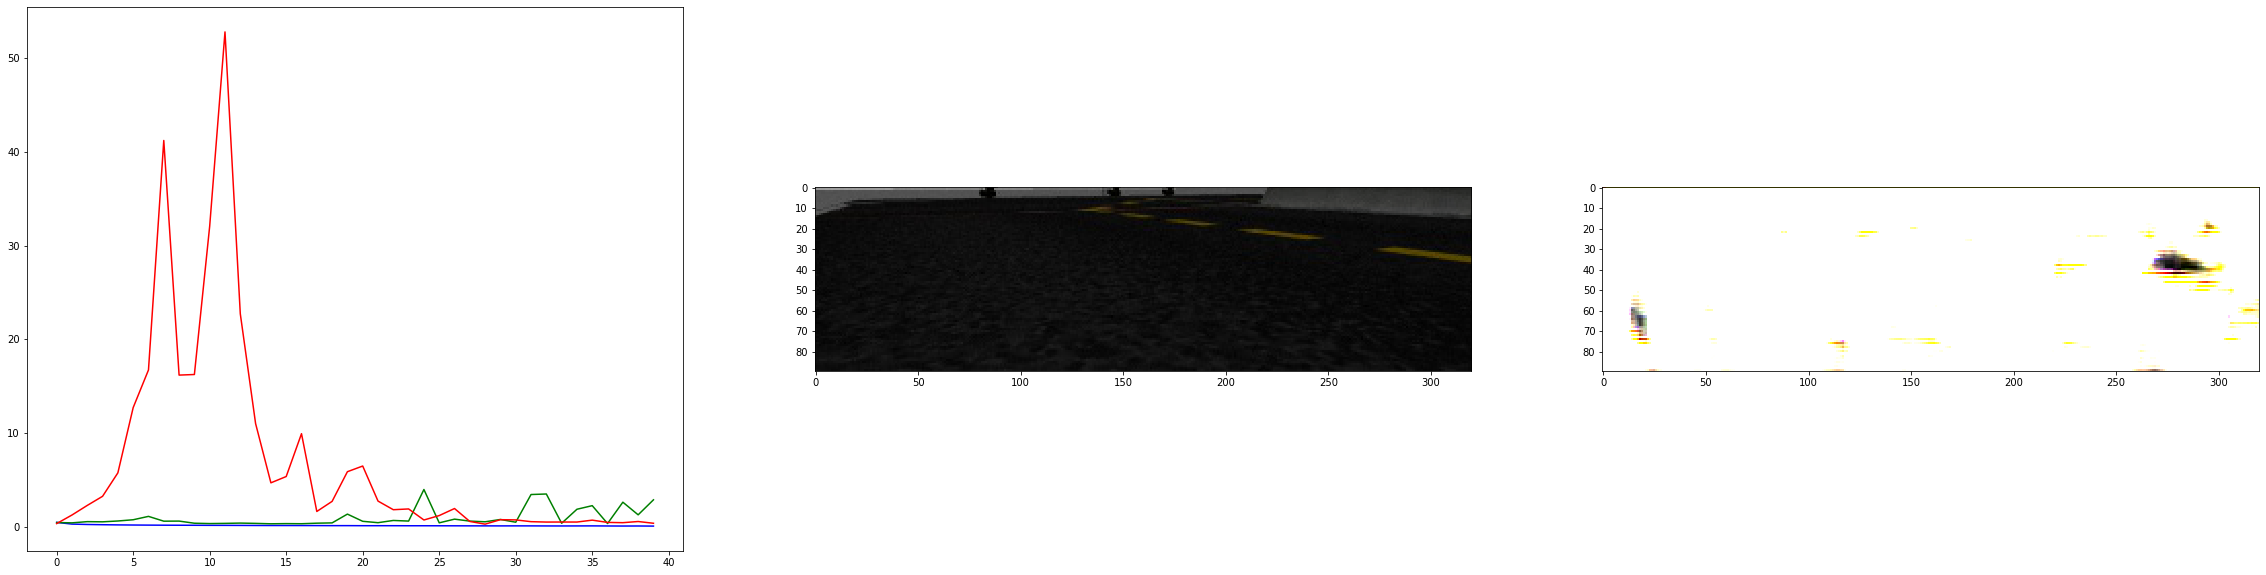

[0.5374222737550736, 0.3550548052787781, 0.3132491761445999, 0.2892298746109009, 0.2693424737453461, 0.25600716054439543, 0.24625780791044236, 0.2376590132713318, 0.23304565668106078, 0.22879440128803252, 0.2222669905424118, 0.2198705592751503, 0.21421553581953048, 0.20728218734264373, 0.203370680809021, 0.20188040256500245, 0.20042776197195053, 0.19684122055768966, 0.18952256232500075, 0.19065804451704024, 0.18399636328220367, 0.18404129534959793, 0.1832721358537674, 0.17874772548675538, 0.17828708171844482, 0.17512448161840438, 0.17286410927772522, 0.1679196438193321, 0.16612888395786285, 0.1635714590549469, 0.16649010479450227, 0.16407884627580643, 0.15835798233747483, 0.1561313220858574, 0.15990071684122087, 0.164554443359375, 0.15467039376497269, 0.14862094104290008, 0.15325881510972977, 0.14249498546123504]
#########
[0.5224730610847473, 0.48719395995140075, 0.6156056255102158, 0.5964691698551178, 0.6851434230804443, 0.8171760559082031, 1.1762292563915253, 0.6651784837245941, 0.6

In [13]:
from IPython.display import clear_output

num_epochs = 40
train_steps_per_epoch = 50
test_steps_per_epoch = 10
batch_size = 16

collision_buffer = 35
path_length = 30

# Make Model
navnet = NavNet().to(device)

optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)
# criterion = nn.MSELoss()

train_batch_gen = batch_generator(train_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_normal_batch_gen = batch_generator(test_normal_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_anormal_batch_gen = batch_generator(test_anormal_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)

train_loss = []
normal_test_loss = []
anormal_test_loss = []

for epoch in range(num_epochs):
        
    # Train
    avg_train_loss = 0
    navnet.train()
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        right_masks, right_images, left_masks, left_images = next(train_batch_gen)
        left_input = left_images
        right_input = right_images
        output = navnet(left_input.to(device))
        loss = navnet.loss(output.to(device), right_input.to(device))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    # Normal / Anormal testing
    
    # Normal
    navnet.eval()
    avg_normal_test_loss = 0
    disp_output = None
    disp_input = None
    for step in range(test_steps_per_epoch):
        right_masks, right_images, left_masks, left_images = next(test_normal_batch_gen)
        left_input = left_images
        right_input = right_images
        output = navnet(left_input.to(device))
        loss = navnet.loss(output.to(device), right_input.to(device))
        avg_normal_test_loss += loss.item()
        
        # additional visualization ability
        disp_output = output
        disp_input = left_input
        
    avg_normal_test_loss /= test_steps_per_epoch
    normal_test_loss.append(avg_normal_test_loss)
    
    # Anormal
    navnet.eval()
    avg_anormal_test_loss = 0
    for step in range(test_steps_per_epoch):
        right_masks, right_images, left_masks, left_images = next(test_anormal_batch_gen)
        left_input = left_images
        right_input = right_images
        output = navnet(left_input.to(device))
        loss = navnet.loss(output.to(device), right_input.to(device))
        avg_anormal_test_loss += loss.item()
        
    avg_anormal_test_loss /= test_steps_per_epoch
    anormal_test_loss.append(avg_anormal_test_loss)
    
    
    
    # Plot the losses in realtime
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,3,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(normal_test_loss,  color='green', label='normal test loss')
    plt.plot(anormal_test_loss,  color='red', label='anormal test loss')

    fig.add_subplot(1,3,2)
    plt.imshow(utils.torch_image_to_cv_image(disp_input[0]))
    
    fig.add_subplot(1,3,3)
    plt.imshow(utils.torch_image_to_cv_image(disp_output[0].cpu().detach()))
    
    plt.show()
    
print(train_loss)
print("#########")
print(normal_test_loss)
print("#########")
print(anormal_test_loss)

## Visualize the model

In [14]:
# test structural similarity detector
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = nn.AvgPool2d(3, 1)(x)
    mu_y = nn.AvgPool2d(3, 1)(y)
    mu_x_mu_y = mu_x * mu_y
    mu_x_sq = mu_x.pow(2)
    mu_y_sq = mu_y.pow(2)

    sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
    sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
    sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

    SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
    SSIM = SSIM_n / SSIM_d

    return torch.clamp((1 - SSIM) / 2, 0, 1)

In [15]:
import time, cv2
import numpy as np

patch_side_len = 32
threshold = 0.1
ssim_threshold = 0.0
crop_line = 90

navnet.eval()
dataset = test_anormal_data
for i in range(1, len(dataset.data)):
    img = dataset.read_torch_image(i)
    if len(img) > 0:
        cv_image = utils.torch_image_to_cv_image(img)

        image = img.unsqueeze(0).to(device)
        model_output = navnet(image)
        
        # structural similarity index
        ssim = torch.mean(torch.nn.functional.pad(SSIM(image, model_output), (1,1,1,1)), axis=1).cpu().detach().numpy()
        ssim = (ssim > ssim_threshold).astype(int)
        
        # pixel wise similarity
        heat_map = ((image-model_output)**2).squeeze(0).cpu().detach().transpose(0,2).transpose(0,1).numpy()

        mask = np.mean(heat_map, axis=2)
        mask = (mask > threshold).astype(int)
            
        red = np.ones((cv_image.shape[0], cv_image.shape[1])) * mask
        green = np.ones((cv_image.shape[0], cv_image.shape[1])) * (1 - mask)
        color_mask = np.zeros(cv_image.shape)
        color_mask[:,:,0] = red
        color_mask[:,:,1] = green
        color_mask = (color_mask*255).astype('uint8')
        
        color_mask = cv2.medianBlur(color_mask,17)
        display_image_pix = cv2.addWeighted((cv_image*255).astype('uint8'),0.7,color_mask,0.3,0)  
        
        red_ssim = np.ones((cv_image.shape[0], cv_image.shape[1])) * ssim
        green_ssim = np.ones((cv_image.shape[0], cv_image.shape[1])) * (1 - ssim)
        color_mask_ssim = np.zeros(cv_image.shape)
        color_mask_ssim[:,:,0] = red_ssim
        color_mask_ssim[:,:,1] = green_ssim
        color_mask_ssim = (color_mask_ssim*255).astype('uint8')
        
        color_mask_ssim = cv2.medianBlur(color_mask_ssim,17)
        display_image_ssim = cv2.addWeighted((cv_image*255).astype('uint8'),0.7,color_mask_ssim,0.3,0)  
        
        display_image = np.hstack((display_image_pix, display_image_ssim))

        cv2.imshow('image', cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(50)

## Save the model

In [16]:
# Standard pytorch model saving/loading
name = "navnetv2-anomaly-detector"
torch.save(navnet.state_dict(), name + ".pt")

### Load the model

In [30]:
# test reloading model
navnet.load_state_dict(torch.load(name + ".pt"))

RuntimeError: Error(s) in loading state_dict for NavNet:
	Missing key(s) in state_dict: "encoder.3.running_mean", "encoder.3.running_var", "encoder.4.weight", "encoder.4.bias", "encoder.7.weight", "encoder.7.bias", "encoder.7.running_mean", "encoder.7.running_var", "encoder.8.weight", "encoder.8.bias", "encoder.11.weight", "encoder.11.bias", "encoder.11.running_mean", "encoder.11.running_var", "decoder.3.weight", "decoder.3.bias", "decoder.3.running_mean", "decoder.3.running_var", "decoder.5.weight", "decoder.5.bias", "decoder.7.running_mean", "decoder.7.running_var", "decoder.11.weight", "decoder.11.bias". 
	Unexpected key(s) in state_dict: "encoder.6.weight", "encoder.6.bias", "decoder.4.weight", "decoder.4.bias". 
	size mismatch for encoder.3.weight: copying a param with shape torch.Size([64, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.9.weight: copying a param with shape torch.Size([3, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for decoder.9.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).

In [61]:
print(train_loss)
print("#########")
print(normal_test_loss)
print("#########")
print(anormal_test_loss)

[0.6688515681028366, 0.2963658165931702, 0.2769834965467453, 0.2648134389519691, 0.2593169477581978, 0.25685531556606295, 0.25542760640382767, 0.25343327313661573, 0.24954727232456209, 0.25127545893192293, 0.25378009378910066, 0.25195181131362915, 0.24920806020498276]
#########
[0.405816850066185, 0.38036020994186404, 0.3760845273733139, 0.38020035028457644, 0.40594032406806946, 0.38532046377658846, 0.38611037135124204, 0.40185423493385314, 0.40006292760372164, 0.4139836311340332, 0.3948966145515442, 0.3942937582731247, 0.4029597699642181]
#########
[1.5762927174568175, 5.078408521413803, 4.139848190546036, 2.5430901825428007, 4.34694222509861, 4.072764492034912, 4.020204263925552, 4.63559855222702, 4.44353546500206, 6.028179669380188, 4.398224014043808, 4.515504971146584, 5.0185388833284374]
